In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

In [3]:
# Load the dataset
df = pd.read_csv('preprocessed_hourly_data.csv')

# Check the first few rows
print(df.head())

              datetime     Timestamp  Open  High  Low  Close  SMA_200  \
0  2012-01-09 17:00:00  1.326128e+09   6.9   6.9  6.5    6.5  5.83495   
1  2012-01-09 18:00:00  1.326132e+09   6.5   6.6  6.5    6.5  5.84455   
2  2012-01-09 19:00:00  1.326136e+09   6.5   6.6  6.5    6.6  5.85465   
3  2012-01-09 20:00:00  1.326139e+09   6.6   6.6  6.6    6.6  5.86475   
4  2012-01-09 21:00:00  1.326143e+09   6.6   6.6  6.6    6.6  5.87485   

    ATR_168  
0  0.032560  
1  0.033155  
2  0.033750  
3  0.033750  
4  0.033750  


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [5]:
print(df.columns.tolist())

['Timestamp', 'Open', 'High', 'Low', 'Close', 'SMA_200', 'ATR_168']


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Select the columns you want to scale (for example, open, high, low, close, volume)
scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'SMA_200', 'ATR_168']])

# Convert the scaled data back into a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close', 'SMA_200', 'ATR_168'], index=df.index)

In [7]:
def create_sequences(data, time_steps=60):
    X = []
    y = []

    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])  # Sequence of 60 previous minutes
        y.append(data[i, 3])  # Target is the 'close' price

    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(scaled_data, time_steps=60)

# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
model = Sequential()

# First GRU layer
model.add(GRU(units=100, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

# Second GRU layer (optional)
model.add(GRU(units=100, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 100)        │        32,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,101 (363.68 KB)

 Trainable params: 93,101 (363.68 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 128s 87ms/step - loss: 5.3024e-04 - mae: 0.0116 - val_loss: 3.5814e-04 - val_mae: 0.0147
Epoch 2/50
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 137s 94ms/step - loss: 1.5432e-04 - mae: 0.0072 - val_loss: 2.9012e-04 - val_mae: 0.0158
Epoch 3/50
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 180s 124ms/step - loss: 1.3424e-04 - mae: 0.0069 - val_loss: 4.1765e-04 - val_mae: 0.0114
Epoch 4/50
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 136s 93ms/step - loss: 1.3624e-04 - mae: 0.0070 - val_loss: 8.9016e-04 - val_mae: 0.0152
Epoch 5/50
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 123s 84ms/step - loss: 1.2553e-04 - mae: 0.0066 - val_loss: 0.0019 - val_mae: 0.0339
Epoch 6/50
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 114s 78ms/step - loss: 1.2904e-04 - mae: 0.0068 - val_loss: 1.8140e-04 - val_mae: 0.0075
Epoch 7/50
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 112s 77ms/step - loss: 1.2415e-04 - mae: 0.0066 - val_loss: 4.1193e-04 - val_mae: 0.0174
Epoch 8/50
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 115s 79ms/step - loss: 1.2079e-04 - mae: 0.0

In [11]:
# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

728/728 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 1.5948e-04 - mae: 0.0102
Test Loss: 0.0005487308953888714
Test MAE: 0.01733941026031971


In [12]:
# Make predictions
predicted_prices = model.predict(X_test)

728/728 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step


In [13]:
# Ensure y_test_actual contains the actual 'Close' prices for the test set
y_test_actual = y_test  # 'y_test' already represents the 'Close' prices, so no need to reshape

# Reshape predicted prices for inverse transformation
predicted_prices = predicted_prices.reshape(-1, 1)

# Now inverse transform only the 'Close' prices
predicted_prices = scaler.inverse_transform(np.concatenate((np.zeros((predicted_prices.shape[0], 5)), predicted_prices), axis=1))[:, 5]
y_test_actual = scaler.inverse_transform(np.concatenate((np.zeros((y_test_actual.shape[0], 5)), y_test_actual.reshape(-1, 1)), axis=1))[:, 5]


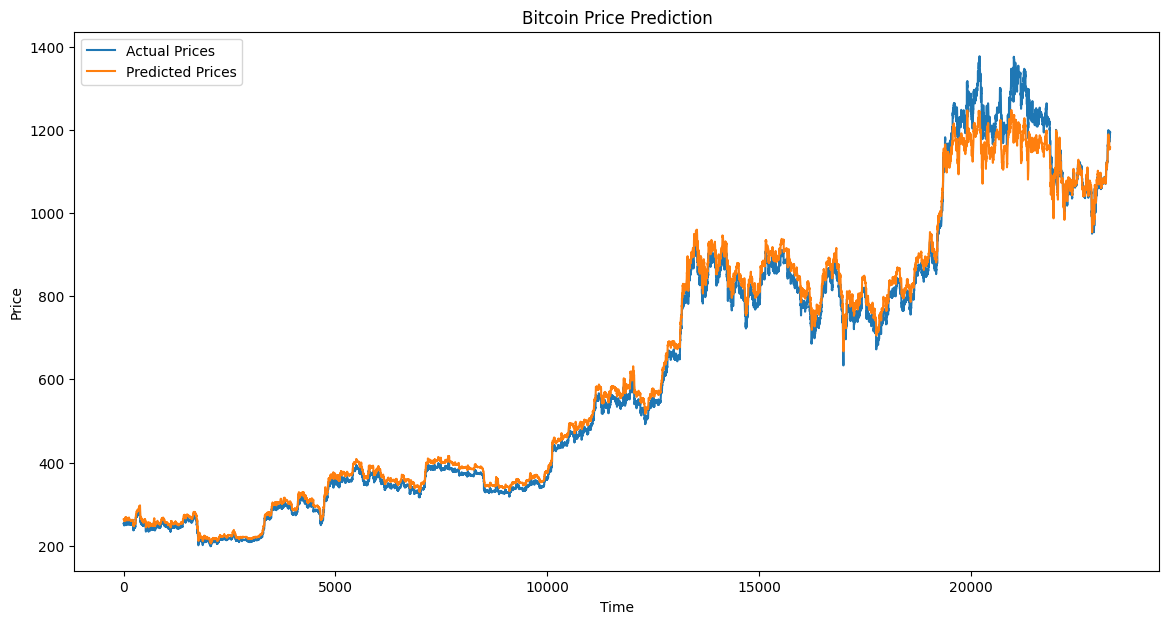

In [14]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label="Actual Prices")
plt.plot(predicted_prices, label="Predicted Prices")
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

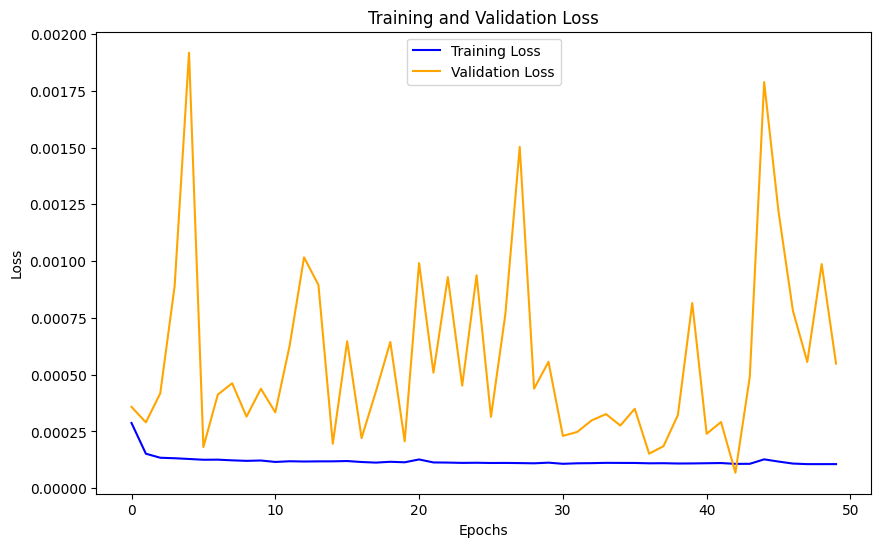

In [15]:
# Plot Training and Validation Loss curves
plt.figure(figsize=(10, 6))

# Training Loss
plt.plot(history.history['loss'], label='Training Loss', color='blue')

# Validation Loss
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

# Adding title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add legend
plt.legend()

# Show the plot
plt.show()